## Machine Learning Introduction
Let's start by writing the Python code for downloading the IRIS dataset and performing an exploratory analysis.


In [37]:
%pip install wandb

In [32]:

import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

import wandb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np


In [2]:


# Load the IRIS dataset
iris_data = load_iris()
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris_data.target, iris_data.target_names)

# Display the first few rows of the dataset
print("First few rows of the IRIS dataset:")
print(iris_df.head())

# Basic statistics of the dataset
print("\nBasic statistics of the dataset:")
print(iris_df.describe())



First few rows of the IRIS dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Basic statistics of the dataset:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600

In [14]:
# iris_df['species'] = pd.Categorical.from_codes(iris_data.target, iris_data.target_names)
# iris_df

In [3]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


## Exploratory Analysis:

First Few Rows: The first few rows of the dataset are displayed to give an idea of the data structure.

Basic Statistics: Descriptive statistics such as count, mean, standard deviation, min, and max values for each feature are shown. This provides an overview of the distribution and scale of each feature.

Pairplot: A pairplot is generated using Seaborn to visualize the pairwise relationships between the features, with each species represented by different colors. This helps in understanding the correlation and distribution of the features across different species.

Correlation Matrix: A heatmap of the correlation matrix shows the correlation coefficients between different features. This helps in understanding the linear relationship between pairs of features.

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


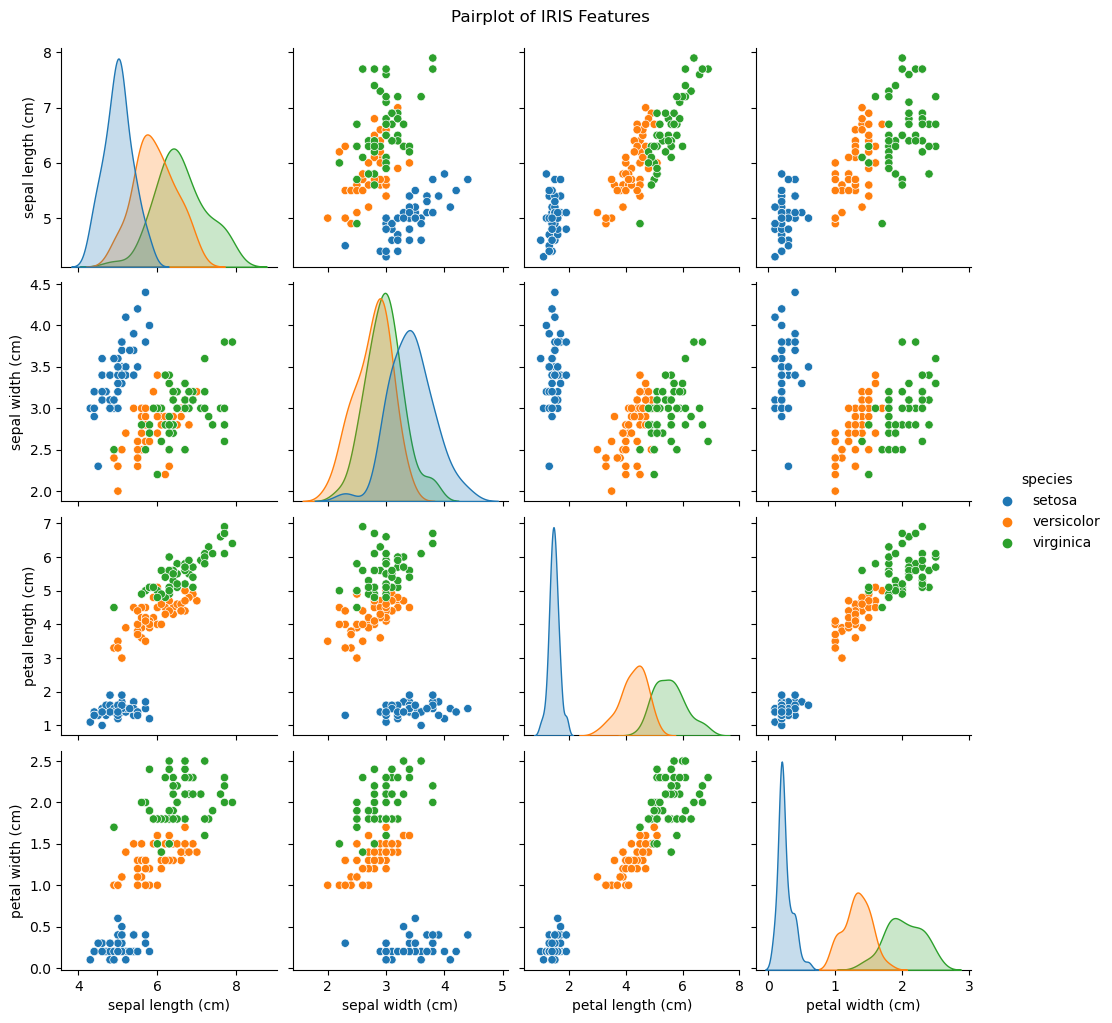

In [4]:
# Pairplot to visualize the relationships between features
sns.pairplot(iris_df, hue='species')
plt.suptitle("Pairplot of IRIS Features", y=1.02)
plt.show()




<Figure size 1000x800 with 0 Axes>

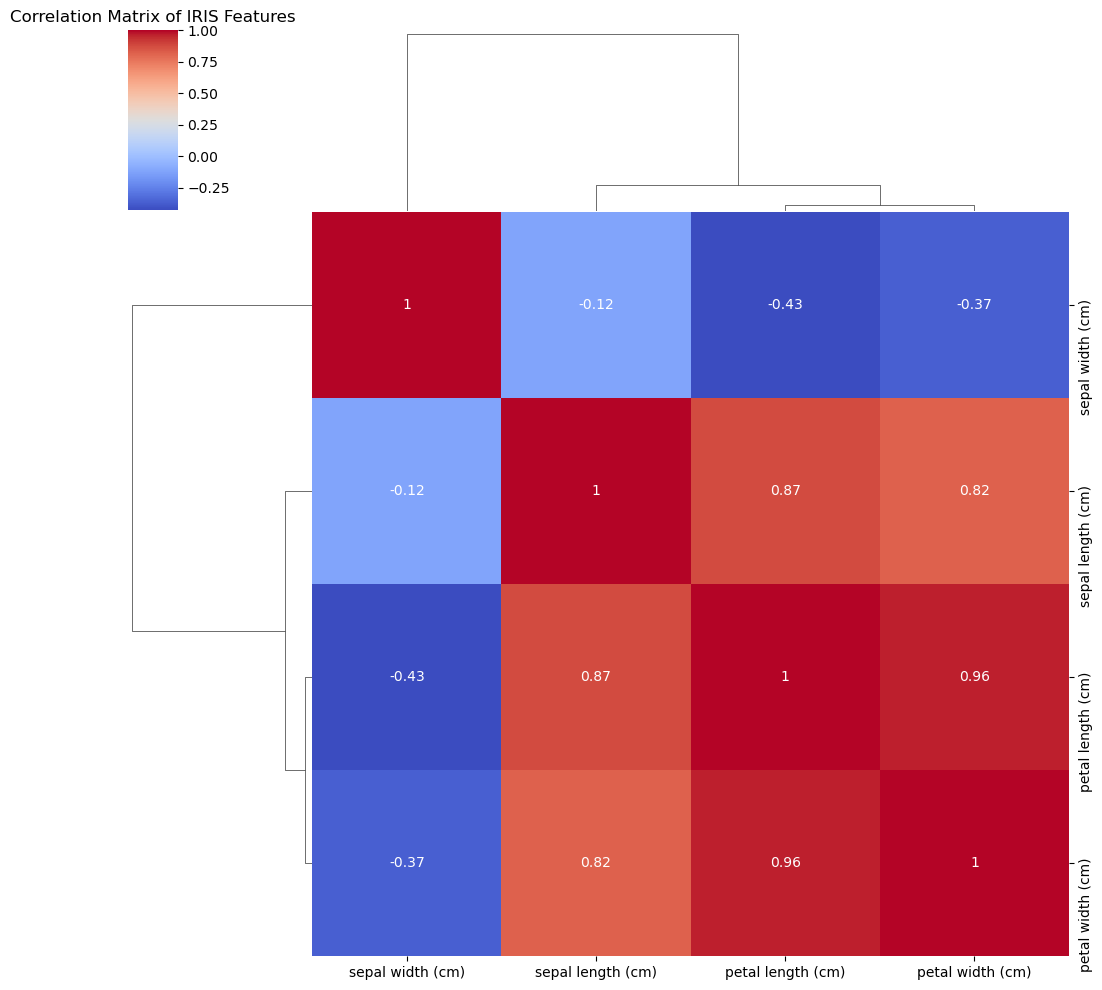

In [5]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.clustermap(iris_df.iloc[:,:4].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of IRIS Features")
plt.show()

# Checking for missing data and detecting outliers using the Interquartile Range (IQR)

### Importance of Outlier Detection

Outlier detection is a critical step in data preprocessing for several reasons:

1. **Impact on Model Performance**: Outliers can significantly distort statistical analyses and predictive modeling. They often lead to erroneous or biased results because many machine learning algorithms are sensitive to the range and distribution of attribute values.

2. **Data Quality**: Outliers may indicate data entry errors, measurement errors, or legitimate but extreme variations in the dataset. Identifying outliers helps in assessing the quality of the data and deciding whether to exclude, adjust, or retain these values in the dataset.

3. **Insight into Data**: Sometimes, outliers can be of particular interest, especially if they represent anomalies that are crucial to business insights or scientific inquiry. For example, in fraud detection or medical diagnostics, outliers can be more interesting than the 'normal' data.

### The Interquartile Range (IQR) Method for Outlier Detection

The Interquartile Range (IQR) is a measure of statistical dispersion and is used as a robust method to detect outliers. Here's how it works:

1. **Calculate the Quartiles**: The dataset is divided into four equal parts after sorting the data. The values that separate these parts are called the first quartile (Q1, 25th percentile), the second quartile (Q2, median), and the third quartile (Q3, 75th percentile).

2. **Compute the IQR**: The IQR is the difference between the third and first quartile (IQR = Q3 - Q1). It represents the middle 50% of the data.

3. **Identify Outliers**: Outliers are typically defined as observations that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR. This rule of thumb is based on the assumption that data is normally distributed, and it covers approximately 99.3% of the data under this assumption. Points outside this range are considered potential outliers.

The IQR method is preferred over standard deviation in many cases because it is not affected by extremely large or small values (which can skew the mean and standard deviation). This makes IQR a more robust and reliable method for outlier detection, especially in skewed distributions.

In [6]:

# Check for missing data
missing_data = iris_df.isnull().sum()
print("Missing Data in Each Column:")
print(missing_data)


# Excluding the 'species' column for calculating IQR
numerical_iris_df = iris_df.select_dtypes(include=['float64', 'int64'])

Q1 = numerical_iris_df.quantile(0.25)
Q3 = numerical_iris_df.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = ((numerical_iris_df < (Q1 - 1.5 * IQR)) | (numerical_iris_df > (Q3 + 1.5 * IQR))).any(axis=1)
outliers_df = iris_df[outliers]

print("Outliers in the dataset:")
print(outliers_df)


Missing Data in Each Column:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64
Outliers in the dataset:
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
15                5.7               4.4                1.5               0.4   
32                5.2               4.1                1.5               0.1   
33                5.5               4.2                1.4               0.2   
60                5.0               2.0                3.5               1.0   

       species  
15      setosa  
32      setosa  
33      setosa  
60  versicolor  


In [7]:
# Define a function to exclude outliers from the dataset based on the "remove_outliers" condition

def process_iris_data(iris_df, remove_outliers=False):
    if remove_outliers:
        # Calculate IQR for numerical columns
        numerical_iris_df = iris_df.select_dtypes(include=['float64', 'int64'])
        Q1 = numerical_iris_df.quantile(0.25)
        Q3 = numerical_iris_df.quantile(0.75)
        IQR = Q3 - Q1

        # Define the condition for non-outlier data
        non_outliers_condition = ~((numerical_iris_df < (Q1 - 1.5 * IQR)) | (numerical_iris_df > (Q3 + 1.5 * IQR))).any(axis=1)

        # Filter the dataset to exclude outliers
        filtered_iris_df = iris_df[non_outliers_condition]
        return filtered_iris_df
    else:
        # Return the original dataset if no outlier removal is required
        return iris_df

# Applying the function to remove outliers
remove_outliers = True
processed_iris_df = process_iris_data(iris_df, remove_outliers=remove_outliers)

# Displaying the first few rows of the processed dataset
processed_iris_df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


# Train/Test splitting
### Importance of Train/Test Split in Machine Learning

Train/test splitting is a fundamental practice in machine learning for several reasons:

1. **Model Evaluation**: It provides a reliable assessment of the performance of a model on an independent dataset. By training on one set of data and testing on a separate set, you get a better understanding of how the model will perform on unseen data.

2. **Overfitting Prevention**: It helps in detecting overfitting. Overfitting occurs when a model learns the details and noise in the training data to the extent that it negatively impacts the performance of the model on new data. By having a separate test set, you can ensure that the model generalizes well.

3. **Model Tuning**: It allows for effective tuning of model parameters. Parameters can be adjusted, and their performance can be evaluated on the test set, ensuring that any improvements are a result of genuine learning and not just memorizing the training data.

4. **Cross-Validation**: In some cases, train/test splitting can be extended to techniques like k-fold cross-validation, which provides a more robust evaluation by using multiple different splits, further improving the reliability of the model evaluation.



In [8]:
from sklearn.model_selection import train_test_split

# Preparing the data
X = processed_iris_df.drop('species', axis=1)
y = processed_iris_df['species']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Displaying the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (116, 4)
X_test shape: (30, 4)
y_train shape: (116,)
y_test shape: (30,)


# Actual ML part. Let's start with a simple Decision Tree Classifier
### What is a Decision Tree?

A Decision Tree is a flowchart-like tree structure where an internal node represents a feature (or attribute), a branch represents a decision rule, and each leaf node represents the outcome. It's a popular machine learning algorithm used for both classification and regression tasks.

#### Logic Behind Decision Trees

- **Node Splitting**: The idea is to split the nodes of the tree into sub-nodes based on some criteria (like information gain or Gini impurity) to make as distinct groups as possible at each level.
- **Recursion and Tree Building**: Starting from the root of the tree, the dataset is divided based on feature values. This process is recursive and continues until a stopping criterion (like maximum depth or minimum samples per leaf) is met.
- **Classification or Regression**: In classification, the outcome at each leaf node represents a class label, whereas in regression, it represents a continuous value.

### Main Hyperparameters of a Decision Tree

1. **`max_depth`**: The maximum depth of the tree. Deeper trees can model more complex patterns but are more prone to overfitting.
2. **`min_samples_split`**: The minimum number of samples required to split an internal node. Higher values prevent the model from learning overly specific patterns (overfitting).
3. **`min_samples_leaf`**: The minimum number of samples required to be at a leaf node. Setting this higher can smooth the model, especially for regression.
4. **`criterion`**: The function to measure the quality of a split. Common criteria are 'gini' for Gini impurity and 'entropy' for information gain in classification tasks.



In [9]:

# Training the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)


DecisionTreeClassifier()

### Explaining Decision Tree Node Selection with Gini Index

The Gini index is a metric that measures the impurity of a dataset; it's used in Decision Trees to decide the optimal way to split the nodes. The idea is to minimize impurity in the nodes, aiming for homogenous sub-nodes after each split.

#### Gini Index Formula
The Gini Index $ G $ for a set of items with \( J \) classes is calculated as:

$ G = 1 - \sum_{j=1}^{J} p_j^2 $

where \( p_j \) is the proportion of items labeled with class \( j \) in the set.

#### How Nodes are Selected

1. **Calculate Gini for Each Split**: For each feature, calculate the Gini index for every possible split.
2. **Choose the Split with the Lowest Gini Index**: The split that results in the lowest Gini index is chosen as it represents the most pure split.

#### Example

Imagine a simple dataset with 10 samples belonging to two classes (A and B):

- 6 samples of class A
- 4 samples of class B

Now, let's consider a split that divides these 10 samples into two groups:

- Group 1: 2 samples of class A, 2 samples of class B
- Group 2: 4 samples of class A, 2 samples of class B

##### Calculating Gini Index for Group 1
Proportions:
- $ p_A = \frac{2}{4} = 0.5 $
- $ p_B = \frac{2}{4} = 0.5 $

Gini Index:
$ G_1 = 1 - (p_A^2 + p_B^2) = 1 - (0.5^2 + 0.5^2) = 1 - (0.25 + 0.25) = 0.5 $

##### Calculating Gini Index for Group 2
Proportions:
- $ p_A = \frac{4}{6} \approx 0.67 $
- $ p_B = \frac{2}{6} \approx 0.33 $

Gini Index:
$ G_2 = 1 - (p_A^2 + p_B^2) \approx 1 - (0.67^2 + 0.33^2) \approx 1 - (0.4489 + 0.1089) \approx 0.4422 $

##### Weighted Gini Index for the Split
$ G_{\text{split}} = \frac{4}{10} \times G_1 + \frac{6}{10} \times G_2 \approx \frac{4}{10} \times 0.5 + \frac{6}{10} \times 0.4422 \approx 0.4653 $

The Decision Tree will consider many such splits for all features and select the one with the lowest weighted Gini index as the point to make the split. This process continues recursively, building the tree one node at a time, until a stopping criterion is reached.

# Evaluation
## Main Metrics in a Classification Report

A classification report typically includes several key metrics that help evaluate the performance of a classification model. Here are the main ones:

1. **Accuracy**: The proportion of total number of predictions that were correct. It's a good measure when the classes are balanced but can be misleading when dealing with imbalanced datasets.
   $ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $

2. **Precision**: The proportion of positive identifications that were actually correct. It answers the question: "Of all the instances labeled as positive, how many are actually positive?"
   $ \text{Precision} = \frac{\text{True Positives (TP)}}{\text{TP + False Positives (FP)}} $

3. **Recall (Sensitivity or True Positive Rate)**: The proportion of actual positives that were identified correctly. It helps understand the model's ability to find all positive instances.
   $ \text{Recall} = \frac{\text{TP}}{\text{TP + False Negatives (FN)}} $

4. **F1 Score**: The harmonic mean of precision and recall. It's a good way to express the balance between precision and recall, especially in imbalanced datasets.
   $ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}} $

### Interpretation of a Confusion Matrix

A confusion matrix is a table often used to describe the performance of a classification model. It summarizes the number of correct and incorrect predictions with count values and is broken down by each class. Here's how to interpret it:

- **True Positives (TP)**: The cases in which the model correctly predicted the positive class.
- **True Negatives (TN)**: The cases in which the model correctly predicted the negative class.
- **False Positives (FP)**: The cases in which the model incorrectly predicted the positive class (a type I error).
- **False Negatives (FN)**: The cases in which the model incorrectly predicted the negative class (a type II error).

The confusion matrix allows not only for the calculation of accuracy but also for the derivation of metrics like precision, recall, and the F1 score. It gives a more detailed breakdown of the model's performance, especially in datasets where the classes are imbalanced. It can also help identify if a model is biased towards one class, if it's particularly prone to false positives or false negatives, etc.

Accuracy of Decision Tree Classifier: 0.9333333333333333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.88      0.88      0.88         8
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.92      0.92      0.92        30
weighted avg       0.93      0.93      0.93        30



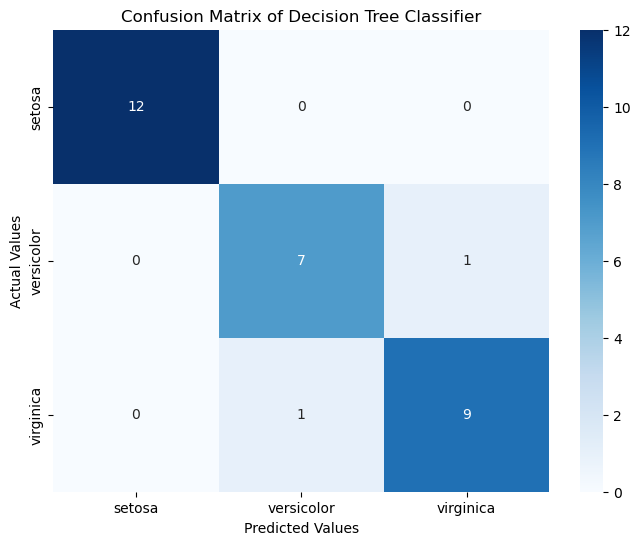

In [10]:

# Predicting on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluating the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Decision Tree Classifier: {accuracy}")

print(classification_report(y_test, y_pred,target_names=iris_data.target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=iris_data.target_names, yticklabels=iris_data.target_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix of Decision Tree Classifier')
plt.show()

# Hyperparameter Tuning in Machine Learning

Hyperparameter tuning is an essential process in building an effective machine learning model. It involves experimenting with different settings for the model's hyperparameters to find the combination that yields the best performance. 

#### Using Weights & Biases (wandb) for Experiment Tracking

Weights & Biases (wandb) is a powerful tool for tracking experiments in machine learning. It helps in logging model parameters, metrics, and outputs during training, allowing for a systematic comparison of different runs. Here's how to use wandb in the context of hyperparameter tuning:

1. **Initialize Wandb**: Start by initializing wandb in your script. This will start a new experiment in wandb.
2. **Log Hyperparameters and Metrics**: As you train models with different hyperparameters, log these along with the performance metrics like accuracy, precision, recall, and F1 score.

#### Hyperparameter Tuning with Cross-Validation and Random Search

- **Cross-Validation (CV)**: This involves splitting the training data into several smaller sets and training the model on each. It provides a more robust estimate of the model's performance.
- **Random Search**: Unlike grid search, random search allows us to randomly sample from a range of hyperparameters, providing a more efficient way to find the best parameters.

### Procedure for Hyperparameter Tuning with Random Search and CV

1. **Define Hyperparameter Space**: Specify the range of values for each hyperparameter. For a Decision Tree, this might include `max_depth`, `min_samples_split`, `min_samples_leaf`, etc.

2. **Choose Preprocessing Techniques**: Include different preprocessing techniques like StandardScaler, MinMaxScaler, and RobustScaler in the hyperparameter space.

3. **Perform Random Search with CV**: Use random search to explore different combinations of hyperparameters and preprocessing techniques. During each iteration, apply cross-validation to assess the performance of the model.

4. **Track Experiments with wandb**: For each iteration, log the hyperparameters and the resulting performance metrics (accuracy, precision, recall, F1 score) in wandb.

5. **Select the Best Model**: After completing the search, choose the model with the best performance metrics.


In [11]:
sweep_config = {
    'method': 'random',  # Can be 'grid', 'random', or 'bayesian'
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'max_depth': {
            'values': [1, 5, 30, None]
        },
        'min_samples_split': {
            'values': [2, 5, 10]
        },
        'min_samples_leaf': {
            'values': [1, 2, 4]
        },
        'preprocessing': {
            'values': ['standard_scaler', 'min_max_scaler', 'robust_scaler', 'none']
        }
    }
}


In [12]:
sweep_id = wandb.sweep(sweep_config, project='hyperparameter_tuning', entity='matteoferrante')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: z1jqs2jm
Sweep URL: https://wandb.ai/matteoferrante/hyperparameter_tuning/sweeps/z1jqs2jm


In [13]:

def train():
    with wandb.init() as run:
        config = run.config

        # Define the classifier with hyperparameters from wandb config
        classifier = DecisionTreeClassifier(max_depth=config.max_depth,
                                            min_samples_split=config.min_samples_split,
                                            min_samples_leaf=config.min_samples_leaf)

        # Define preprocessing
        preprocessing = None
        if config.preprocessing == 'standard_scaler':
            preprocessing = StandardScaler()
        elif config.preprocessing == 'min_max_scaler':
            preprocessing = MinMaxScaler()
        elif config.preprocessing == 'robust_scaler':
            preprocessing = RobustScaler()

        # Create pipeline
        pipeline = Pipeline([('preprocessing', preprocessing), ('classifier', classifier)])
        print(pipeline.steps[-1][-1].get_params())
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5)

        # Perform cross-validation and calculate metrics
        accuracy_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
        precision_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='precision_macro')
        recall_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall_macro')
        f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')

        # Log average metrics to wandb
        wandb.log({
            'accuracy': accuracy_scores.mean(), 
            'precision': precision_scores.mean(), 
            'recall': recall_scores.mean(), 
            'f1_score': f1_scores.mean()
        })


In [14]:
wandb.agent(sweep_id, train, count=3)  # Adjust 'count' as needed


wandb: Agent Starting Run: mtun2qrv with config:
wandb: 	max_depth: 30
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 5
wandb: 	preprocessing: standard_scaler
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante. Use `wandb login --relogin` to force relogin


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.96522
f1_score,0.9666
precision,0.96852
recall,0.96667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xnqho05b with config:
wandb: 	max_depth: 1
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	preprocessing: none
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


c:\Users\matte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedM

accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.65507
f1_score,0.55726
precision,0.50196
recall,0.66667


wandb: Agent Starting Run: rqm3qrhs with config:
wandb: 	max_depth: 1
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 10
wandb: 	preprocessing: none
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


c:\Users\matte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedM

accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.65507
f1_score,0.55726
precision,0.50196
recall,0.66667


# Retrieve optimal parameters

In [15]:
sweep_id

'z1jqs2jm'

In [16]:

# API call to download the sweep results
api = wandb.Api()
sweep = api.sweep(f"matteoferrante/hyperparameter_tuning/{sweep_id}") #"your_username/project_name/sweep_id")
runs = sweep.runs

# Extracting metrics and parameters from each run
run_data = [{"id": run.id, "parameters": run.config, "metrics": run.summary} for run in runs]

def find_best_run(run_data, metric='f1_score'):
    best_run = max(run_data, key=lambda r: r["metrics"][metric])
    return best_run

# Specify the metric, default to 'f1_score'
chosen_metric = 'f1_score'  # Replace with user-specified metric if needed
best_run = find_best_run(run_data, metric=chosen_metric)

print("Best Run Parameters:", best_run["parameters"])
print("Best Run Metrics:", best_run["metrics"])


Best Run Parameters: {'max_depth': 30, 'preprocessing': 'standard_scaler', 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Run Metrics: {'f1_score': 0.9666013071895424, 'accuracy': 0.9652173913043478, 'precision': 0.9685185185185186, '_timestamp': 1699869833.5376103, '_step': 0, '_wandb': {'runtime': 14}, 'recall': 0.9666666666666666, '_runtime': 15.91401433944702}


# Train and evaluate the optimal Decision Tree

Final Model Accuracy on Test Set: 0.9333333333333333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.88      0.88      0.88         8
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.92      0.92      0.92        30
weighted avg       0.93      0.93      0.93        30



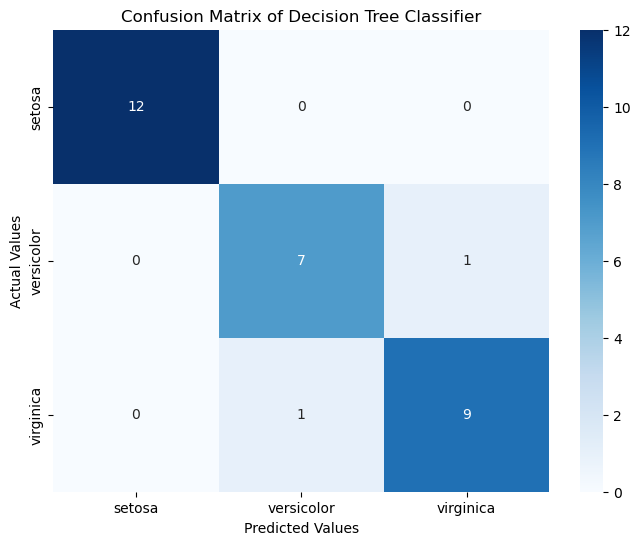

In [17]:

# Extracting the best parameters
best_params = best_run["parameters"]

# Define preprocessing based on best_params
preprocessing = None
if best_params['preprocessing'] == 'standard_scaler':
    preprocessing = StandardScaler()
elif best_params['preprocessing'] == 'min_max_scaler':
    preprocessing = MinMaxScaler()
elif best_params['preprocessing'] == 'robust_scaler':
    preprocessing = RobustScaler()

# Create and train the final model with best parameters
final_classifier = DecisionTreeClassifier(max_depth=best_params['max_depth'],
                                          min_samples_split=best_params['min_samples_split'],
                                          min_samples_leaf=best_params['min_samples_leaf'])

final_pipeline = Pipeline([('preprocessing', preprocessing), ('classifier', final_classifier)])
final_pipeline.fit(X_train, y_train)

# Optionally, evaluate the final model on the test set
final_predictions = final_pipeline.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)
print("Final Model Accuracy on Test Set:", final_accuracy)


print(classification_report(y_test, final_predictions,target_names=iris_data.target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=iris_data.target_names, yticklabels=iris_data.target_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix of Decision Tree Classifier')
plt.show()


## Visualize output

In [40]:
X_train.columns.tolist()

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

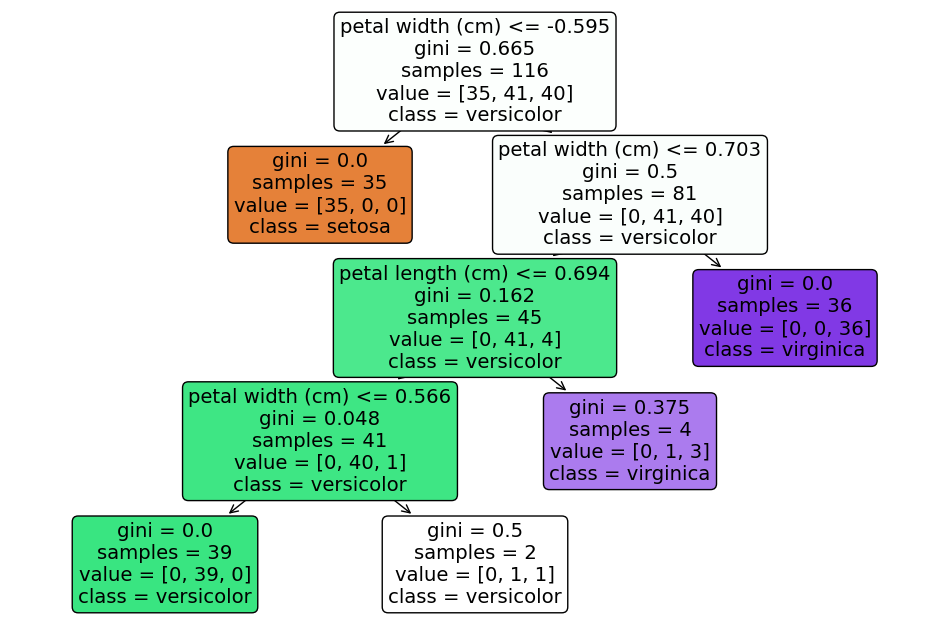

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


# Plotting the tree
plt.figure(figsize=(12, 8))
plot_tree(final_pipeline["classifier"], filled=True, feature_names=X_train.columns.tolist(), class_names=iris_data.target_names.tolist(), rounded=True)
plt.show()


Text(0.5, 1.0, 'Feature Importance')

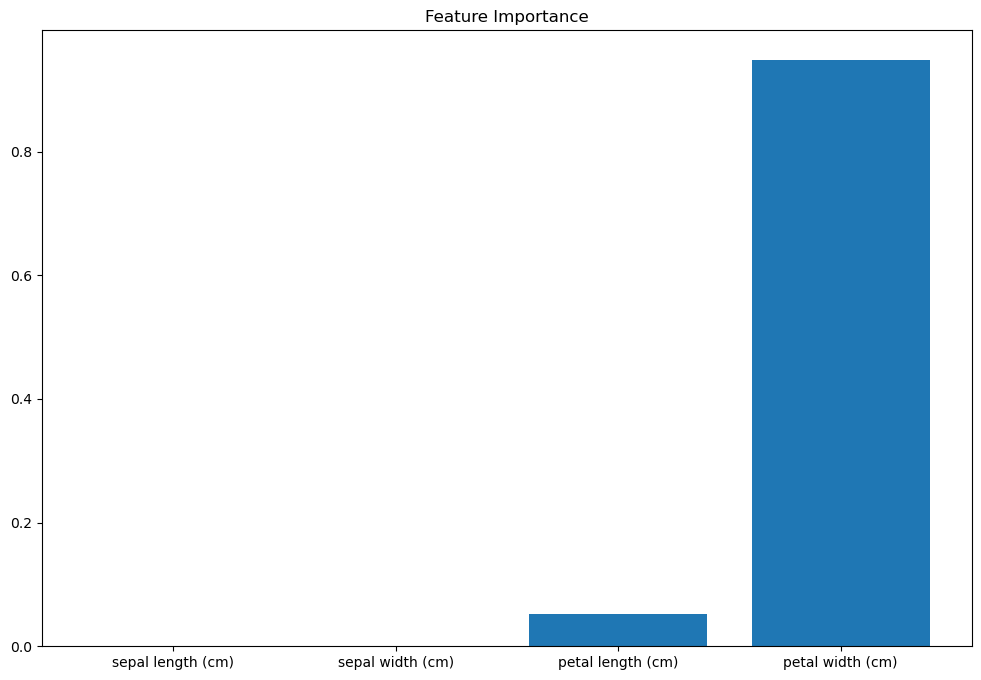

In [19]:
#plot feature importance
plt.figure(figsize=(12, 8))
plt.bar(X_train.columns.tolist(), final_pipeline["classifier"].feature_importances_)
plt.title("Feature Importance")
# final_pipeline["classifier"].feature_importances_

### What is a RandomForest?

A Random Forest is an ensemble learning method, primarily used for classification and regression. It operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (for classification) or mean prediction (for regression) of the individual trees.

#### Inner Mechanism of Random Forest

1. **Bootstrap Aggregating (Bagging)**: Random Forest creates multiple decision trees using subsets of the original dataset. These subsets are generated through bootstrap sampling, which means randomly selecting samples from the dataset with replacement.

2. **Random Feature Selection**: At each split in the construction of a tree, only a subset of features is considered for selection. This randomness helps in making the model more robust and prevents overfitting.

3. **Combining Predictions**: After training, predictions from all individual trees are combined to make a final prediction. In classification, this is typically done by majority voting; in regression, it's by averaging the outputs.

### Main Hyperparameters of Random Forest

1. **`n_estimators`**: Number of trees in the forest. More trees increase robustness but also computational cost.

2. **`max_depth`**: Maximum depth of each tree. Deeper trees can capture more complex patterns but might lead to overfitting.

3. **`min_samples_split`**: Minimum number of samples required to split an internal node. 

4. **`min_samples_leaf`**: Minimum number of samples required to be at a leaf node.

5. **`max_features`**: The number of features to consider when looking for the best split. 

6. **`bootstrap`**: Whether bootstrap samples are used when building trees.


In [20]:
sweep_config = {
    'method': 'random',  # Can be 'grid', 'random', or 'bayesian'
    'metric': {
      'name': 'accuracy',  # Can be changed based on the goal (e.g., 'f1_score')
      'goal': 'maximize'   
    },
    'parameters': {
        'n_estimators': {
            'values': [10, 50, 100, 200]
        },
        'max_depth': {
            'values': [10, 20, 30, None]
        },
        'min_samples_split': {
            'values': [2, 5, 10]
        },
        'min_samples_leaf': {
            'values': [1, 2, 4]
        },
        'max_features': {
            'values': ['auto', 'sqrt']
        },
        'bootstrap': {
            'values': [True, False]
        },
        'preprocessing': {
            'values': ['standard_scaler', 'min_max_scaler', 'robust_scaler', 'none']
        }
    }
}



In [21]:
from sklearn.ensemble import RandomForestClassifier

def train_rf():
    with wandb.init() as run:
        config = run.config

        # Define the RandomForest classifier with hyperparameters
        rf_classifier = RandomForestClassifier(n_estimators=config.n_estimators,
                                               max_depth=config.max_depth,
                                               min_samples_split=config.min_samples_split,
                                               min_samples_leaf=config.min_samples_leaf,
                                               max_features=config.max_features,
                                               bootstrap=config.bootstrap)

        # Define preprocessing
        preprocessing = None
        if config.preprocessing == 'standard_scaler':
            preprocessing = StandardScaler()
        elif config.preprocessing == 'min_max_scaler':
            preprocessing = MinMaxScaler()
        elif config.preprocessing == 'robust_scaler':
            preprocessing = RobustScaler()

        # Create pipeline
        pipeline = Pipeline([('preprocessing', preprocessing), ('rf_classifier', rf_classifier)])

        # Perform cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')  # Can use other metrics

        # Log metrics to wandb
        wandb.log({'accuracy': cv_scores.mean()})


In [22]:
perform_search=False ## Set true to run a new sweep 
if perform_search:
    sweep_id_rf = wandb.sweep(sweep_config, project='random_forest_hyperparameter_tuning', entity='matteoferrante')
    wandb.agent(sweep_id_rf, train, count=5)  # Adjust 'count' as needed


In [24]:
## Choose a RF set of parameters and train the model
# Define the RandomForest classifier with hyperparameters if you need the best one after search use the same code as above to retrieve them from wandb
rf_classifier = RandomForestClassifier(n_estimators=200,
                                        max_depth=10,
                                        min_samples_split=5,
                                        min_samples_leaf=1,
                                        max_features='sqrt',
                                        bootstrap=True)

# Define preprocessing
preprocessing = StandardScaler()

# Create pipeline
pipeline = Pipeline([('preprocessing', preprocessing), ('rf_classifier', rf_classifier)])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Random Forest Classifier: {accuracy}")
print("classifcation report",classification_report(y_test, y_pred,target_names=iris_data.target_names))

Accuracy of Random Forest Classifier: 0.9333333333333333
classifcation report               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.88      0.88      0.88         8
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.92      0.92      0.92        30
weighted avg       0.93      0.93      0.93        30



## Feature Importance

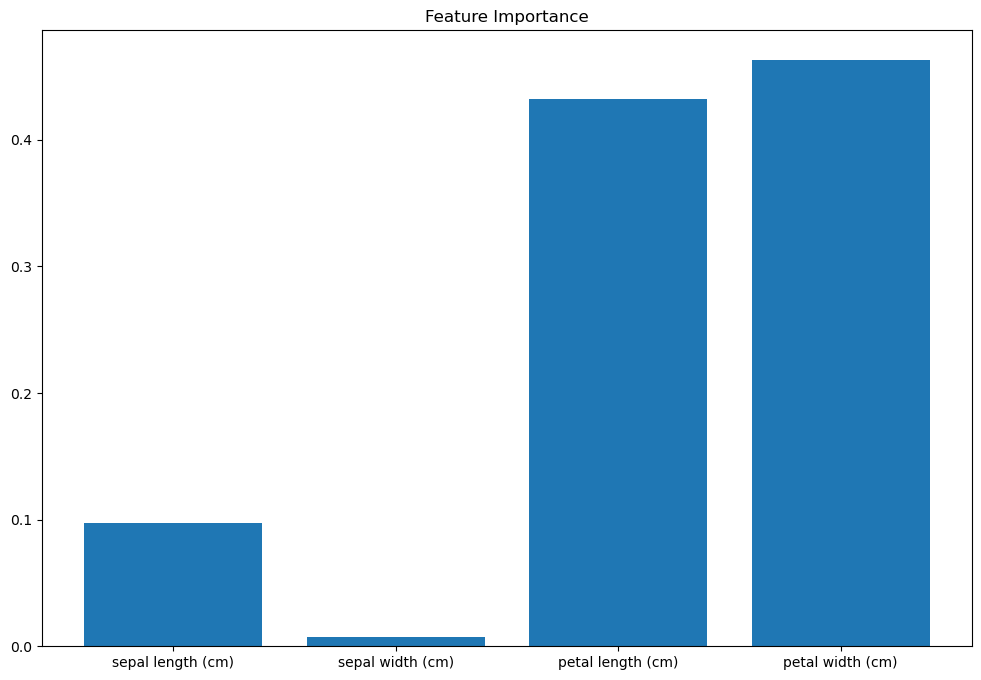

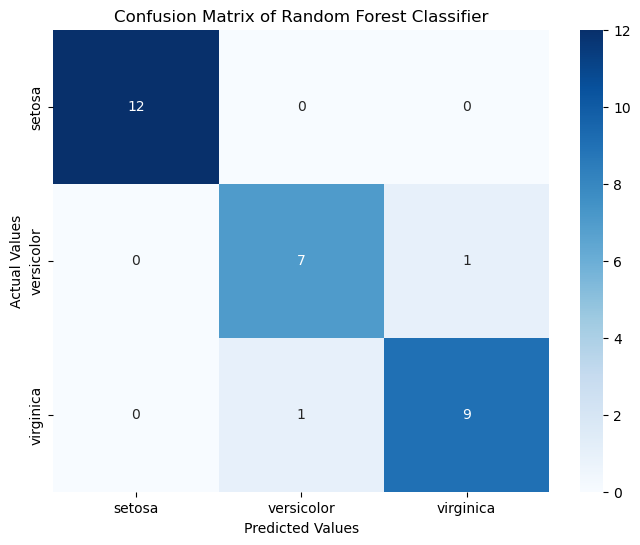

In [25]:
#plot feature   importance
plt.figure(figsize=(12, 8))
plt.bar(X_train.columns.tolist(), pipeline["rf_classifier"].feature_importances_)
plt.title("Feature Importance")
# final_pipeline["classifier"].feature_importances_

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=iris_data.target_names, yticklabels=iris_data.target_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix of Random Forest Classifier')
plt.show()


### What is XGBoost?

XGBoost (eXtreme Gradient Boosting) is an advanced and highly efficient implementation of gradient boosted trees designed for speed and performance. It's a popular choice for many machine learning competitions and practical applications. 

#### Key Features of XGBoost

1. **Gradient Boosting Framework**: XGBoost is based on the gradient boosting framework, where new models are added sequentially to correct the errors made by existing models.

2. **Regularization**: It includes L1 and L2 regularization which helps in reducing overfitting.

3. **Handling of Missing Values**: XGBoost has an in-built routine to handle missing values.

4. **Tree Pruning**: The splitting of a tree in XGBoost is depth-wise compared to other algorithms that do breadth-wise splitting. It also uses a technique called 'pruning' where splits are made up to the max_depth and then pruned back if they don’t contribute to a gain in the objective function.

5. **Built-in Cross-Validation**: XGBoost allows users to run a cross-validation at each iteration of the boosting process.

6. **Parallel and Distributed Computing**: It uses parallel computing and is incredibly fast compared to other implementations of gradient boosting.

7. **Flexibility**: It supports various objective functions and evaluation criteria.

8. **Handling Sparse Data**: XGBoost is well-suited for sparse data and can handle different types of sparse data formats.


Remember, XGBoost's versatility allows it to be tuned for a wide range of data types and distributions, and its parameters can significantly influence the model's performance and speed.

In [26]:
%pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/bc/43/242432efc3f60052a4a534dc4926b21e236ab4ec8d4920c593da3f65c65d/xgboost-2.0.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 660.6 kB/s eta 0:02:31
   ---------------------------------------- 0.5/99.8 MB 3.4 MB/s eta 0:00:30
   ---------------------------------------- 1.0/99.8 MB 5.2 MB/s eta 0:00:19
    --------------------------------------- 1.5/99.8 MB 6.6 MB/s eta 0:00:15
    --------------------------------------- 1.9/99.8 MB 7.3 MB/s eta 0:00:14
    --------------------------------------- 2.5/99.8 MB 7.9 MB/s eta 0:00:13
   - -------------------------------------- 3.0/99.8 MB 8.3 MB/s eta 0:00:12
   - -------------------------------------- 

XGBoost (eXtreme Gradient Boosting) is a highly sophisticated and efficient implementation of gradient boosting, a machine learning technique. Understanding its mechanism requires diving into several key aspects:

### 1. Gradient Boosting Framework

XGBoost is built on the principle of gradient boosting, which involves the following steps:

- **Sequential Model Building**: Unlike algorithms that build models in isolation, gradient boosting builds one tree at a time. Each new tree is created to correct the errors made by the previous trees.
- **Error Correction**: Each tree learns from its predecessor and updates the residual errors. The final prediction is a weighted sum of these sequential trees.

### 2. Gradient Optimization

XGBoost improves upon this by using gradient descent to minimize loss when adding new models. This involves:

- **Gradient Descent Step**: For a given loss function (like mean squared error for regression), XGBoost uses gradient descent to minimize this loss when adding a new tree. The algorithm computes the gradient of the loss with respect to the predictions of each tree.
- **Update Rule**: The model's predictions are updated to minimize the loss function, using this gradient.

### 3. Regularization

A key feature that differentiates XGBoost from classical gradient boosting is regularization:

- **Regularization Term**: XGBoost adds a regularization term to the loss function, which penalizes complex models. This includes both L1 (lasso regression) and L2 (ridge regression) regularization. This helps in preventing overfitting.



In [30]:
# y_train
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
label_encoded_y_train = label_encoder.transform(y_train)
label_encoded_y_test = label_encoder.transform(y_test)
label_encoded_y_train

array([0, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0,
       1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1,
       0, 2, 1, 1, 0, 1, 0, 2, 0, 0, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0,
       0, 1, 2, 0, 2, 2, 0, 2, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1,
       1, 2, 0, 1, 1, 0, 2, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2, 2,
       0, 1, 2, 0, 1, 2])

In [35]:

import xgboost as xgb


#encode labels


# Convert the dataset into an optimized data structure called Dmatrix
dtrain = xgb.DMatrix(X_train, label=label_encoded_y_train)
dtest = xgb.DMatrix(X_test, label=label_encoded_y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 3,  # maximum depth of each tree
    'eta': 0.3,      # the learning rate
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3   # the number of classes in the dataset
}

# Number of training iterations
num_round = 20

# Training the model
bst = xgb.train(params, dtrain, num_round)

# Predicting on the test set
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

# Calculating the accuracy
accuracy = accuracy_score(label_encoded_y_test, best_preds)
print(f"Accuracy: {accuracy}")
print(classification_report(label_encoded_y_test, best_preds,target_names=iris_data.target_names))

Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.88      0.88      0.88         8
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.92      0.92      0.92        30
weighted avg       0.93      0.93      0.93        30

